In [4]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ["OPENAI_API_KEY"] = os.getenv("API_KEY")

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# ステートの定義
class State(TypedDict):
    # データを保存する属性
    messages: Annotated[list, add_messages]

# ステートグラフの作成
graph_builder = StateGraph(State)

In [7]:
# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 終了ノードの指定
graph_builder.set_finish_point("chatbot")

# 実行可能なステートグラフの作成
graph = graph_builder.compile()

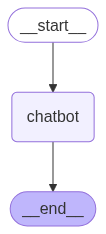

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# グラフの実行
response = graph.invoke({"messages": ["user", "光の三原色は？"]})

# 結果の表示
print(response)

{'messages': [HumanMessage(content='user', additional_kwargs={}, response_metadata={}, id='5b52d5a5-0d78-40b7-8119-2bf5b6bb71b6'), HumanMessage(content='光の三原色は？', additional_kwargs={}, response_metadata={}, id='7f926bf9-c793-478c-9e6b-bcab8e8496a1'), AIMessage(content='光の三原色は、赤 (Red)、緑 (Green)、青 (Blue) の3色です。これらの色を組み合わせることで、さまざまな色を表現することができます。光の三原色は、加法混色の原理に基づいており、色の合成は光の強さを足し合わせることで行われます。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 19, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-BbQN3tXerE7mwobxQMEDNlTcXWOBT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0092ee2a-5d9b-4f16-b692-b3f3ce118865-0', usage_metada

In [11]:
print(response["messages"][-1].content)

光の三原色は、赤 (Red)、緑 (Green)、青 (Blue) の3色です。これらの色を組み合わせることで、さまざまな色を表現することができます。光の三原色は、加法混色の原理に基づいており、色の合成は光の強さを足し合わせることで行われます。


In [12]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    # 結果をストリーミングで得る
    events = graph.stream({"messages": ["user", user_input]})
    for event in events:
        for value in event.values():
            print("回答:", value["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問: ")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    print("質問:", user_input, flush=True)
    stream_graph_updates(user_input)

質問: こんにちは！
回答: こんにちは！どのようにお手伝いできますか？
質問: 光の三原色は？
回答: 光の三原色は、赤（Red）、緑（Green）、青（Blue）の3つです。これらの色を組み合わせることで、さまざまな色を表現することができます。例えば、赤と緑を混ぜると黄色が、緑と青を混ぜるとシアンが、赤と青を混ぜるとマゼンタが得られます。この原理は、ディスプレイや照明などの色の再現に利用されています。
ありがとうございました!


In [13]:
from langgraph.checkpoint.memory import MemorySaver

# チェックポインタの作成
memory = MemorySaver()

# 記憶を持つ実行可能なステートグラフの作成
memory_graph = graph_builder.compile(checkpointer=memory)

In [15]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = memory_graph.stream(
        {"messages": ["user", user_input]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)


# チャットボットのループ
while True:
    user_input = input("質問: ")
    if user_input.strip() == "":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！今日はどんなことをお話ししたいですか？
aで始まる英単語を5つ教えて
もちろんです！「a」で始まる英単語を5つ挙げますね。

1. Apple（リンゴ）
2. Amazing（驚くべき）
3. Adventure（冒険）
4. Artist（アーティスト）
5. Ancient（古代の）

他にも知りたい単語があれば教えてください！
4つ目の英単語は何ですか？
4つ目の英単語は「Artist」です。「アーティスト」という意味で、絵画、音楽、演劇などの分野で創作活動を行う人を指します。何か他に知りたいことがあれば教えてください！
ありがとうございました!
